# 🧾 Challenge:

Telecom X es una empresa de telecomunicaciones. La empresa está enfrentando un alto índice de evasión de clientes y aún no han identificado el problema de esta evasión. Para ello, te han proporcionado algunos datos para identificar la causa del problema y construir modelos predictivos que ayudarán a la empresa Telecom X a anticiparse a la evasión de clientes.

# Bibliotecas

In [33]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [ ]:
from IPython.display import display

# Extracción

In [5]:
df = pd.read_csv('/content/df_tratados.csv')

# Transformación

#### Revisión de columnas y sus valores

Cambiar de nombre a las columnas para facilitar la lectura durante el análisis

In [6]:
df.rename(columns={
    'Evasion': 'Cancelacion',
    'CargoMensual': 'PagoMensual',
    'CargoTotal': 'PagoAcumulado',
    'Cuentas_Diarias': 'PagoDiario'
}, inplace=True)

##### Revisar valores nulos

In [7]:
df.isnull().sum()

,0
ClienteID,0
Cancelacion,0
Genero,0
AdultoMayor,0
Pareja,0
Dependientes,0
MesesContrato,0
ServicioTelefonico,0
LineasMultiples,0
ServicioInternet,0


#### Eliminación de Columnas Irrelevantes: IDCliente

Eliminar columna ID del cliente

In [8]:
df.drop('ClienteID', axis=1, inplace=True)

#### Verificación de la Proporción de Cancelación (Evasión)

La proporción de clientes que se van es de aproximadamente ~ 27%, y los que se quedan ~ 73%.

In [9]:
cancel_counts = df['Cancelacion'].value_counts(normalize=True)
print(cancel_counts)

Cancelacion
No     0.734215
Yes    0.265785
Name: proportion, dtype: float64


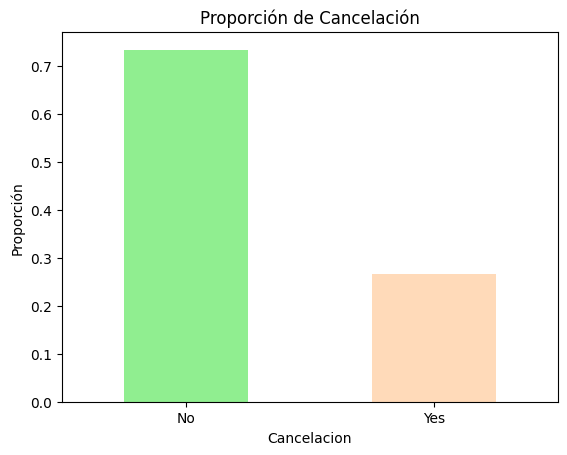

In [10]:
cancel_counts.plot(kind='bar', title='Proporción de Cancelación', color=['lightgreen', 'peachpuff'])
plt.xticks(rotation=0)
plt.ylabel("Proporción")
plt.show()

#### Encoding:

Conversión de los valores de variables categóricas a valores numéricos para su uso en análisis predicitivo

##### 🔷 **Variables Binarias (Label Encoding)**

Genero → 'Male', 'Female'

AdultoMayor → Es booleana

Pareja → 'Yes', 'No'

Dependientes → 'Yes', 'No'

ServicioTelefonico → 'Yes', 'No'

FacturaElectronica → 'Yes', 'No'

**Variable objetivo:**
Cancelacion → 'Yes' = cliente canceló; 'No' = cliente sigue.

In [11]:
binarias = {
    'Genero': {'Female': 0, 'Male': 1},
    'AdultoMayor': {False: 0, True: 1},
    'Pareja': {'No': 0, 'Yes': 1},
    'Dependientes': {'No': 0, 'Yes': 1},
    'ServicioTelefonico': {'No': 0, 'Yes': 1},
    'FacturaElectronica': {'No': 0, 'Yes': 1},
    'Cancelacion': {'No': 0, 'Yes': 1}
}

df.replace(binarias, inplace=True)

/tmp/ipython-input-3659456329.py:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace(binarias, inplace=True)


##### 🔶 **Variables con más de dos valores (One-Hot Encoding)**


LineasMultiples → 'Yes', 'No', 'No phone service'

ServicioInternet → 'DSL', 'Fiber optic', 'No'

SeguridadOnline, RespaldoOnline, ProteccionDispositivo, SoporteTecnico, StreamingTV, StreamingPeliculas → 'Yes', 'No', 'No internet service'

TipoContrato → 'One year', 'Month-to-month', 'Two year'

MetodoPago → 'Mailed check', 'Electronic check', 'Credit card (automatic)', 'Bank transfer (automatic)'

In [12]:
categorias_base = {
    'LineasMultiples': ['No phone service', 'No', 'Yes'],
    'ServicioInternet': ['No', 'DSL', 'Fiber optic'],
    'SeguridadOnline': ['No internet service', 'No', 'Yes'],
    'RespaldoOnline': ['No internet service', 'No', 'Yes'],
    'ProteccionDispositivo': ['No internet service', 'No', 'Yes'],
    'SoporteTecnico': ['No internet service', 'No', 'Yes'],
    'StreamingTV': ['No internet service', 'No', 'Yes'],
    'StreamingPeliculas': ['No internet service', 'No', 'Yes'],
    'TipoContrato': ['Month-to-month', 'One year', 'Two year'],
    'MetodoPago': ['Bank transfer (automatic)', 'Credit card (automatic)', 'Electronic check', 'Mailed check']
}

In [13]:
for col, orden in categorias_base.items():
    df[col] = pd.Categorical(df[col], categories=orden, ordered=True)

In [14]:
df = pd.get_dummies(df, columns=categorias_base.keys(), drop_first=True)

In [15]:
df.columns = df.columns.str.replace('Yes', 'Si', regex=False)
df.columns = df.columns.str.replace('Fiber optic', 'FibraOptica', regex=False)
df.columns = df.columns.str.replace('One year', 'OneYear', regex=False)
df.columns = df.columns.str.replace('Two year', 'TwoYear', regex=False)
df.columns = df.columns.str.replace('Credit card (automatic)', 'TarjetaCreditoAutomatico', regex=False)
df.columns = df.columns.str.replace('Electronic check', 'ElectronicCheck', regex=False)
df.columns = df.columns.str.replace('Mailed check', 'MailedCheck', regex=False)

# Correlación y Selección de Variables

### Análisis de Correlación

En la matriz de correlación, se observa que las variables con alta correlación positiva (clientes que tienden a cancelar) son las siguientes:

- SeguridadOnline_No (0.34)

- SoporteTecnico_No (0.33)

- ServicioInternet_FibraOptica (0.31)

- MetodoPago_ElectronicCheck (0.30)

Ello indica que los clientes sin servicios de soporte tecnico, sin seguridad online, que cuentan con fibra óptica o que pagan con cheque electrónico tienen mayor probabilidad de irse. Esto podría sugerir que no contar con los beneficios de los servicios de seguridad y soporte resulta en una menor fidelización. Asimismo, los usuarios de fibra óptica quizá tengan expectativas altas del servicio que no se cumplen, o algun competidor en el mercado ofrece un mejor servicio de fibra optica. Finalmente, los pagos electrónicos podrían estar ligados a clientes con menos compromiso o más fluctuación.

Por otro lado, existe una correlación negativa fuerte (retención del cliente) en las siguientes variables:

- TipoContrato_TwoYear (−0.30)
- MesesContrato (−0.35)
- PagoAcumulado (−0.20)
- SoporteTecnico_Si, SeguridadOnline_Si

Esto indica que los contratos a largo plazo, mayor antigüedad del cliente, y un pagoacumulado total alto son signos de clientes más leales. Asimismo, tener soporte técnico o seguridad en línea también podrías estar influyendo en la retención del cliente.

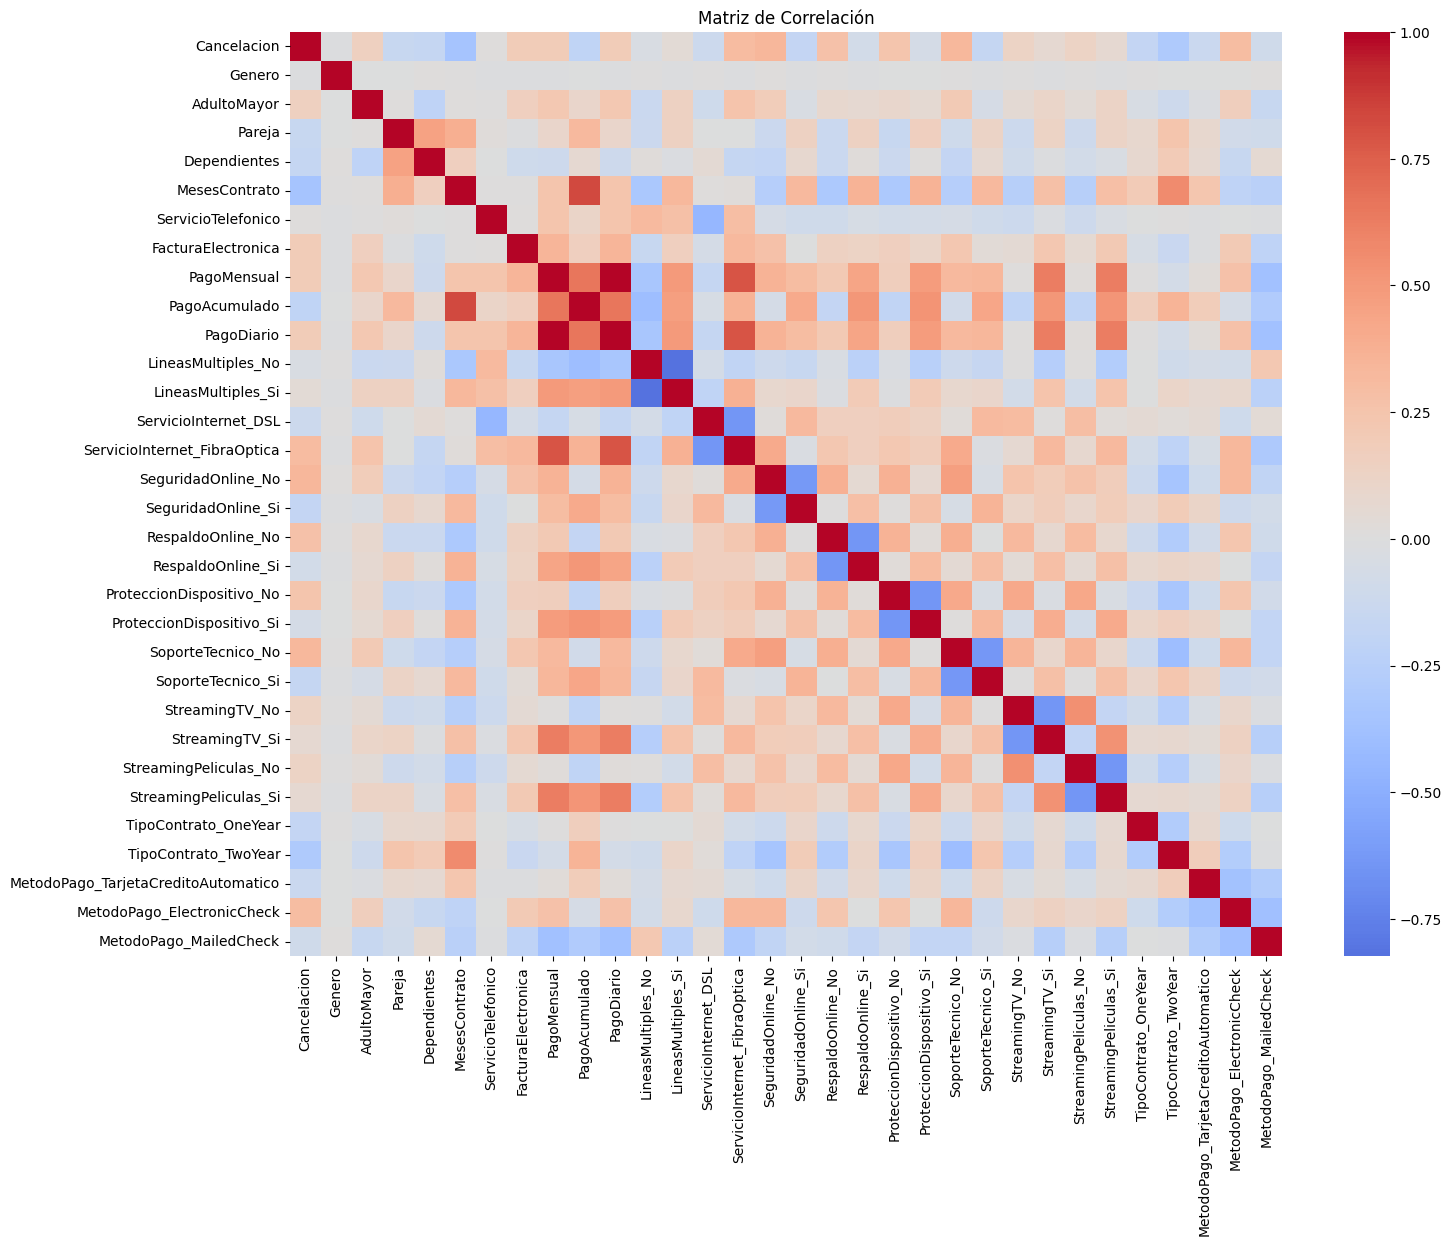

In [17]:
plt.figure(figsize=(16, 12))
correlation_matrix = df.corr(numeric_only=True)

sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', center=0)
plt.title('Matriz de Correlación')
plt.show()

In [18]:
correlation_target = correlation_matrix['Cancelacion'].drop('Cancelacion').sort_values(ascending=False)

In [19]:
print(correlation_target)

SeguridadOnline_No                     0.342235
SoporteTecnico_No                      0.336877
ServicioInternet_FibraOptica           0.307463
MetodoPago_ElectronicCheck             0.301455
RespaldoOnline_No                      0.267595
ProteccionDispositivo_No               0.252056
PagoDiario                             0.192858
PagoMensual                            0.192858
FacturaElectronica                     0.191454
AdultoMayor                            0.150541
StreamingPeliculas_No                  0.130920
StreamingTV_No                         0.128435
StreamingTV_Si                         0.063254
StreamingPeliculas_Si                  0.060860
LineasMultiples_Si                     0.040033
ServicioTelefonico                     0.011691
Genero                                -0.008545
LineasMultiples_No                    -0.032654
ProteccionDispositivo_Si              -0.066193
RespaldoOnline_Si                     -0.082307
MetodoPago_MailedCheck                -0

### Análisis Dirigido

#### Funciones para los calculos

In [20]:
def mostrar_boxplot_cancelacion(variable):
    if variable not in df.columns:
        print(f'{variable} no esta en el dataframe.')
        return

    plt.figure(figsize=(8, 6))
    sns.boxplot(data=df, x='Cancelacion', y=variable, palette='pastel')

    plt.title(f'{variable} vs Cancelación')
    plt.xlabel('Canceló el cliente (0=No, 1=Sí)')
    plt.ylabel(variable)
    plt.show()

In [21]:
def resumen_estadistico_por_cancelacion(df, variables):
    resumenes = []

    for var in variables:
        resumen = df.groupby('Cancelacion')[var].describe().reset_index()
        resumen['Variable'] = var
        resumenes.append(resumen)

    resumen_total = pd.concat(resumenes, ignore_index=True)

    # Reordenar columnas para mejor presentación
    columnas_ordenadas = ['Variable', 'Cancelacion', 'count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']
    return resumen_total[columnas_ordenadas]

In [24]:
def barplot_cancelacion(df, variable, titulo=None):

    if variable not in df.columns:
        print(f"La variable '{variable}' no existe en el DataFrame.")
        return

    # Calcular proporciones de cancelación por grupo (0 y 1)
    prop = df.groupby(variable)['Cancelacion'].value_counts(normalize=True).unstack()

    # Graficar
    plt.figure(figsize=(6, 4))
    prop.plot(kind='bar', stacked=True, color=['lightgreen', 'peachpuff'], ax=plt.gca())

    # Configurar título y ejes
    plot_title = titulo if titulo else f'Proporción de Cancelación por {variable}'
    plt.title(plot_title)
    plt.ylabel('Proporción')
    plt.xlabel(variable)
    plt.xticks(rotation=0)
    plt.legend(title='Cancelacion', loc='upper right')
    plt.tight_layout()
    plt.show()

#### Análisis de variables numéricas con alta correlación

In [22]:
variables_con_alta_corr = ['PagoMensual', 'PagoAcumulado','MesesContrato']
resumen = resumen_estadistico_por_cancelacion(df, variables_con_alta_corr)

display(resumen)

,Variable,Cancelacion,count,mean,std,min,25%,50%,75%,max
0,PagoMensual,0,5163.0,61.307408,31.094557,18.25,25.100,64.45,88.475,118.75
1,PagoMensual,1,1869.0,74.441332,24.666053,18.85,56.150,79.65,94.200,118.35
2,PagoAcumulado,0,5163.0,2555.344141,2329.456984,18.80,577.825,1683.60,4264.125,8672.45
3,PagoAcumulado,1,1869.0,1531.796094,1890.822994,18.85,134.500,703.55,2331.300,8684.80
4,MesesContrato,0,5163.0,37.650010,24.076940,1.00,15.000,38.00,61.000,72.00
5,MesesContrato,1,1869.0,17.979133,19.531123,1.00,2.000,10.00,29.000,72.00


**Meses de Contrato vs Cancelación**

Al observar el gráfico, se nota una clara diferencia entre los clientes que se quedaron y los que cancelaron. Los clientes que no cancelaron tienen un promedio de 37.6 meses, mientras los que se van tiene un promedio de 18 meses.

Los clientes que se fueron tienen una mediana de apenas 10 meses, y el 25% de ellos lo hacen en sus primeros 2 meses. Esto refuerza la idea de que los primeros meses son críticos para la retención.

Además, se observan algunos valores atípicos, pues hay clientes que se fueron después de 72 meses, pero son casos poco frecuentes. Esto indica que aunque no imposible, es muy poco probable que un cliente antiguo se vaya.

/tmp/ipython-input-2795278099.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Cancelacion', y=variable, palette='pastel')


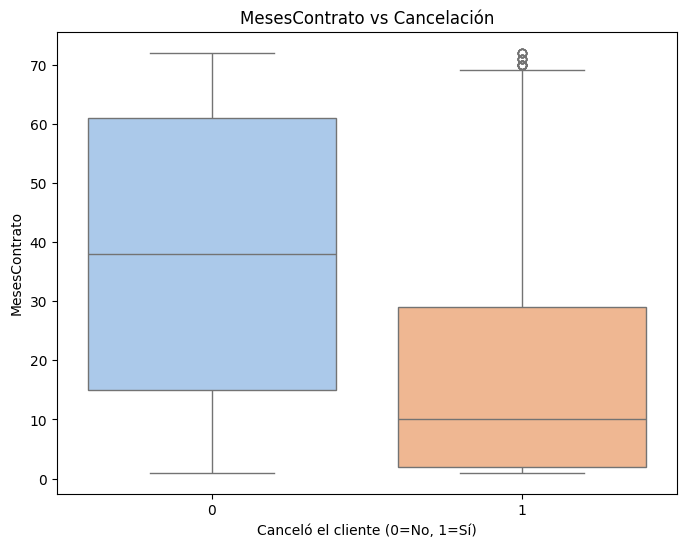

In [26]:
mostrar_boxplot_cancelacion('MesesContrato')

**Pago Mensual vs Cancelación**

El boxplot muestra que los clientes que se fueron tienen pagos mensuales más altos que aquellos que se quedaron. La mediana del grupo que se fue está alrededor de 74.44, mientras que para quienes permanecen está más cerca de 64.31. Esto sugiere que el costo mensual elevado puede contribuir a la decisión de abandonar el servicio. Considerando esto, es posible que los clientes que se van contratan varios servicios de la empresa, pero los servicios adquiridos no cumplen con sus expectativas.

/tmp/ipython-input-2795278099.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Cancelacion', y=variable, palette='pastel')


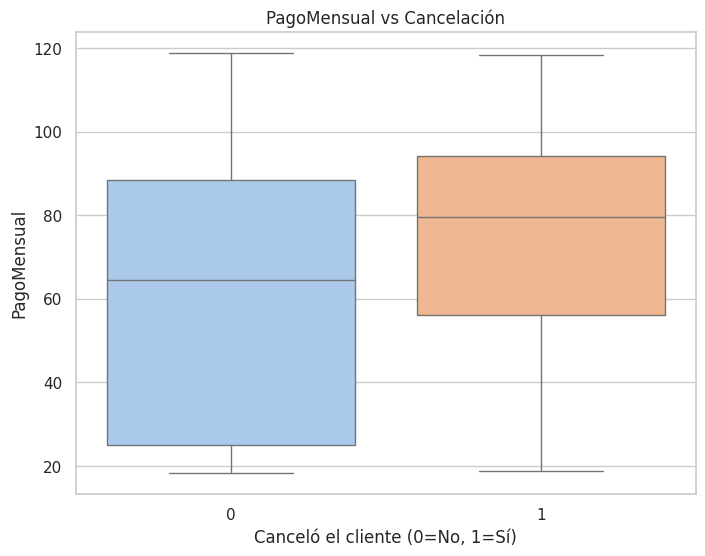

In [92]:
mostrar_boxplot_cancelacion('PagoMensual')

**PagoAcumulado vs Cancelación**

Al observar el gráfico, se encuentra que los clientes que no evadieron han pagado mucho más en total. Los que sí se fueron, en promedio, pagaron mucho menos, aunque hay excepciones. Por ejemplo, en el boxplot, se observan varios valores atípicos fuera del límite superior. A detalle se sabe que uno de los clientes que pagó hasta 8684.80, y se fue. Este es un valor mayor al máximo valor pagado por uno de los clientes que se quedo. Esto explica que los clientes que se van tienen un acumulado bajo de pagos realizados. Además, indica que es poco probable que quienes tienen mucho tiempo con la empresa decidan dejar sus servicios, aunque es posible. Por otro lado, puede indicar malas experiencias tempranas o bajo engagement inicial con los clientes.

/tmp/ipython-input-2795278099.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Cancelacion', y=variable, palette='pastel')


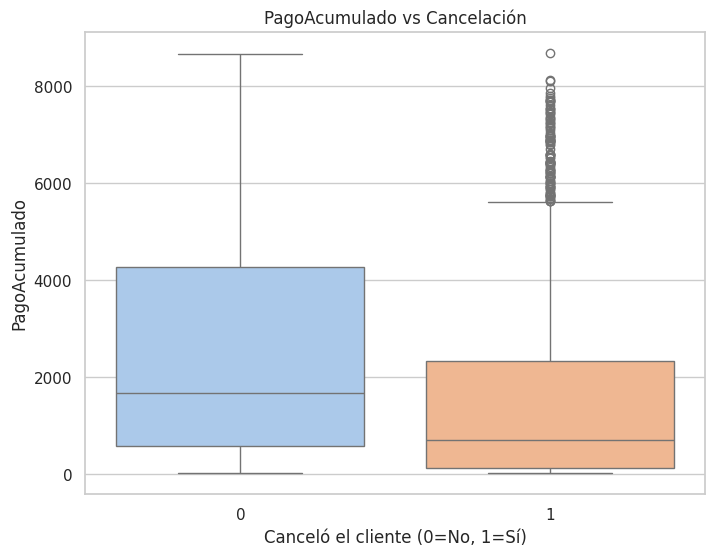

In [165]:
mostrar_boxplot_cancelacion('PagoAcumulado')

#### Variables booleanas

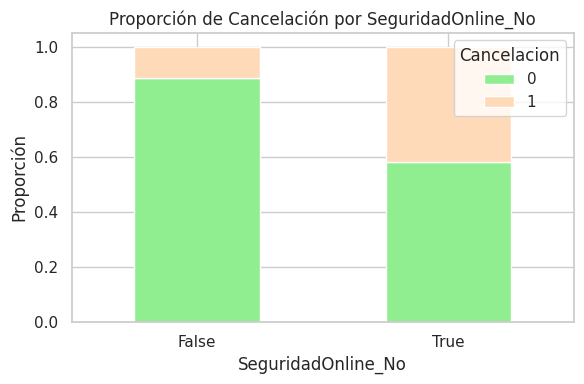

In [169]:
barplot_cancelacion(df, 'SeguridadOnline_No')

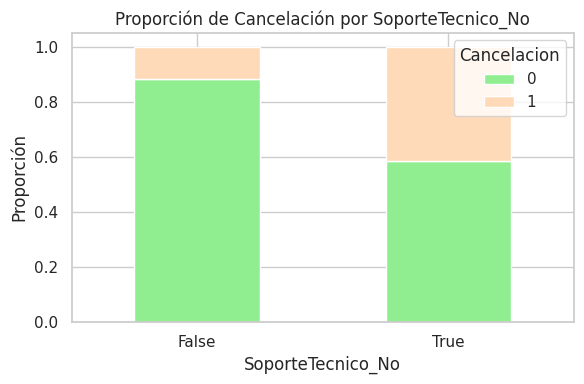

In [170]:
barplot_cancelacion(df,'SoporteTecnico_No')

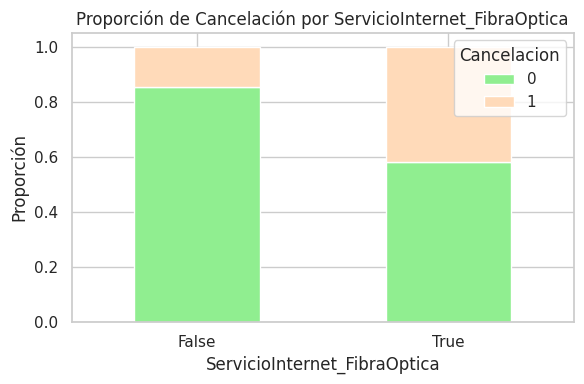

In [171]:
barplot_cancelacion(df,'ServicioInternet_FibraOptica')

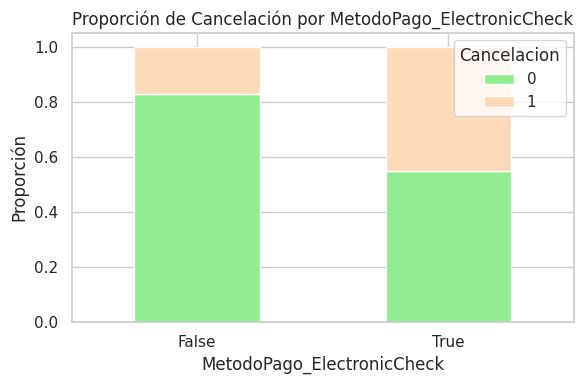

In [172]:
barplot_cancelacion(df,'MetodoPago_ElectronicCheck')

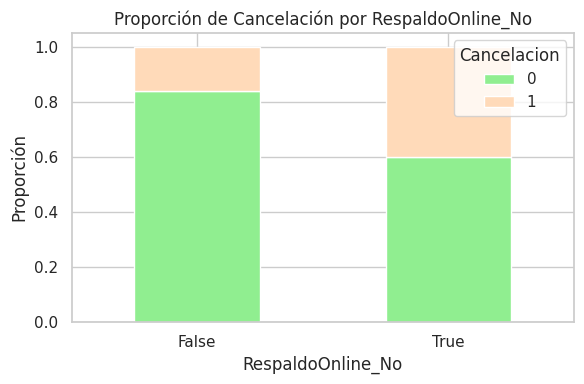

In [173]:
barplot_cancelacion(df,'RespaldoOnline_No')

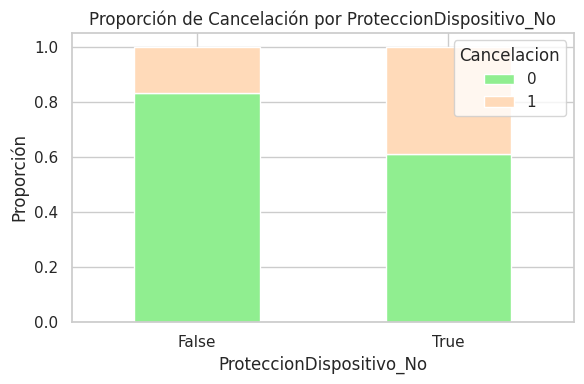

In [174]:
barplot_cancelacion(df,'ProteccionDispositivo_No')

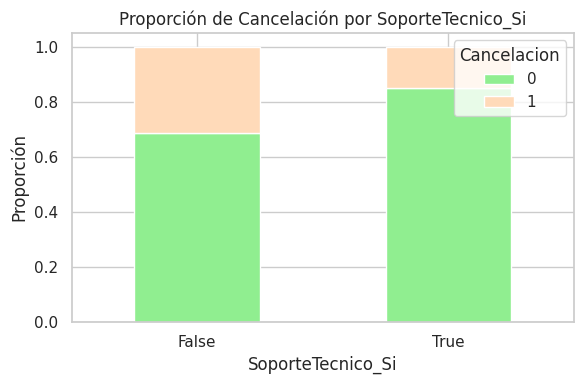

In [175]:
barplot_cancelacion(df,'SoporteTecnico_Si')

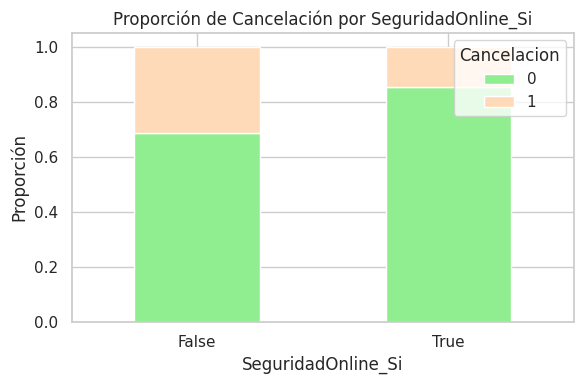

In [176]:
barplot_cancelacion(df,'SeguridadOnline_Si')

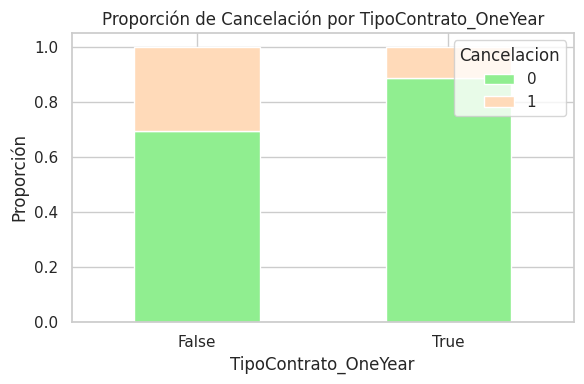

In [177]:
barplot_cancelacion(df,'TipoContrato_OneYear')

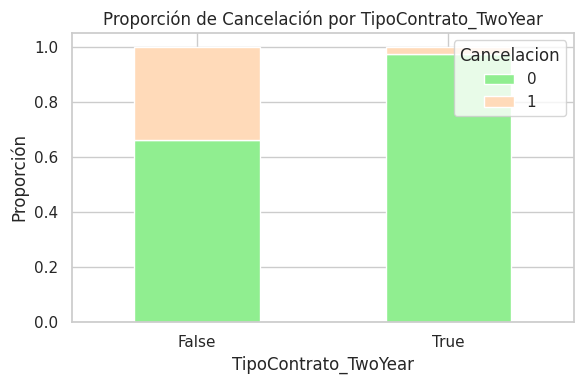

In [178]:
barplot_cancelacion(df,'TipoContrato_TwoYear')

# Modelo Predictivo

## Selección de variables

Considerando el nivel de correlación con la cancelación (+/-0.15), se seleccionó un subconjunto de variables para construir el modelo predictivo.

In [27]:
variables_modelo = [
    'Cancelacion',
    'SeguridadOnline_No', 'SoporteTecnico_No',
    'ServicioInternet_FibraOptica', 'MetodoPago_ElectronicCheck',
    'RespaldoOnline_No', 'ProteccionDispositivo_No',
    'PagoMensual', 'Dependientes', 'SoporteTecnico_Si', 'SeguridadOnline_Si',
    'TipoContrato_OneYear', 'TipoContrato_TwoYear', 'PagoAcumulado', 'MesesContrato'
]

In [28]:
df_modelo = df[variables_modelo].copy()

## Separación de Datos

Considerando el tamaño del dataframe, se opto realizar una división de 70% de los datos para entrebamiento y 30% para prueba.

In [29]:
X = df_modelo.drop(columns='Cancelacion')
y = df_modelo['Cancelacion']

In [30]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

print("Dimensiones de entrenamiento:")
print("X_train:", X_train.shape, "| y_train:", y_train.shape)

print("\nDimensiones de prueba:")
print("X_test:", X_test.shape, "| y_test:", y_test.shape)

Dimensiones de entrenamiento:
X_train: (4922, 14) | y_train: (4922,)

Dimensiones de prueba:
X_test: (2110, 14) | y_test: (2110,)


# Creación de Modelos

## Modelo 1: Random Forest

=== RANDOM FOREST ===
              precision    recall  f1-score   support

           0       0.82      0.88      0.85      1549
           1       0.59      0.48      0.53       561

    accuracy                           0.77      2110
   macro avg       0.70      0.68      0.69      2110
weighted avg       0.76      0.77      0.76      2110



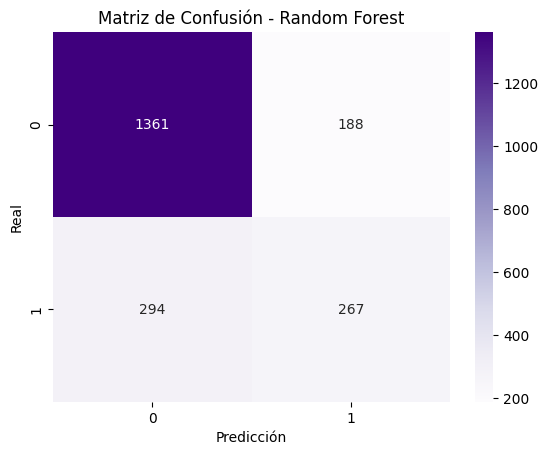

In [31]:
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)  # Entrenamiento con datos de entrenamiento

y_pred_rf = rf_model.predict(X_test)  # Prueba con datos de prueba
print("=== RANDOM FOREST ===")
print(classification_report(y_test, y_pred_rf))
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', cmap='Purples')
plt.title("Matriz de Confusión - Random Forest")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()

In [43]:
# Obtener importancias
importancia_rf = pd.DataFrame({
    'Variable': X_train.columns,
    'Importancia': rf_model.feature_importances_
})
importancia_rf = importancia_rf.sort_values(by='Importancia', ascending=False)

display(importancia_rf)

,Variable,Importancia
12,PagoAcumulado,0.254917
6,PagoMensual,0.239803
13,MesesContrato,0.200879
0,SeguridadOnline_No,0.043618
1,SoporteTecnico_No,0.042364
3,MetodoPago_ElectronicCheck,0.041509
2,ServicioInternet_FibraOptica,0.037059
4,RespaldoOnline_No,0.025932
11,TipoContrato_TwoYear,0.025494
10,TipoContrato_OneYear,0.023916


/tmp/ipython-input-3833162531.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importancia_rf.head(10), x='Importancia', y='Variable', palette='viridis')


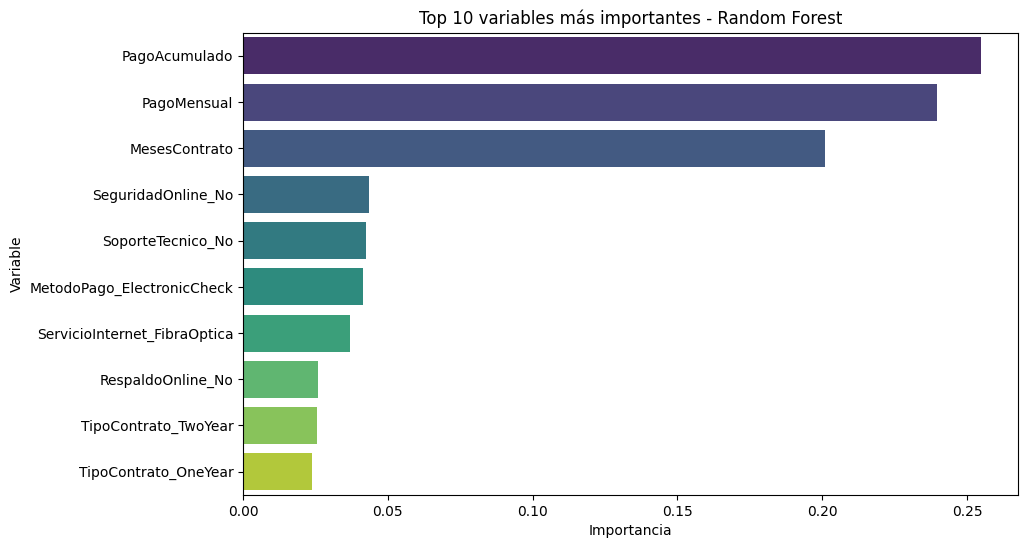

In [44]:
plt.figure(figsize=(10, 6))
sns.barplot(data=importancia_rf.head(10), x='Importancia', y='Variable', palette='viridis')
plt.title('Top 10 variables más importantes - Random Forest')
plt.xlabel('Importancia')
plt.ylabel('Variable')
plt.show()

## Modelo 2: Regresión Logística

In [39]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [40]:
log_model = LogisticRegression(max_iter=1000, random_state=42)
log_model.fit(X_train, y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=1000, random_state=42)

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


=== REGRESIÓN LOGÍSTICA ===
              precision    recall  f1-score   support

           0       0.89      0.75      0.81      1549
           1       0.52      0.75      0.61       561

    accuracy                           0.75      2110
   macro avg       0.71      0.75      0.71      2110
weighted avg       0.79      0.75      0.76      2110



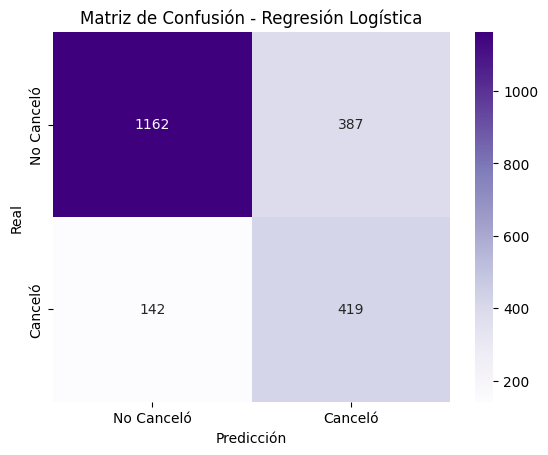

In [41]:
y_pred_log = log_model.predict(X_test_scaled)

print("=== REGRESIÓN LOGÍSTICA ===")
print(classification_report(y_test, y_pred_log))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred_log)
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples',
            xticklabels=['No Canceló', 'Canceló'],
            yticklabels=['No Canceló', 'Canceló'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión - Regresión Logística')
plt.show()

In [42]:
coeficientes = log_model.coef_[0]
variables = X_train.columns

importancia_log = pd.DataFrame({
    'Variable': variables,
    'Coeficiente': coeficientes
})
importancia_log['Importancia_absoluta'] = np.abs(importancia_log['Coeficiente'])
importancia_log = importancia_log.sort_values(by='Importancia_absoluta', ascending=False)

display(importancia_log)

,Variable,Coeficiente,Importancia_absoluta
11,TipoContrato_TwoYear,-1.262229,1.262229
10,TipoContrato_OneYear,-0.710616,0.710616
3,MetodoPago_ElectronicCheck,0.492913,0.492913
2,ServicioInternet_FibraOptica,0.483855,0.483855
1,SoporteTecnico_No,0.395401,0.395401
0,SeguridadOnline_No,0.365916,0.365916
7,Dependientes,-0.175127,0.175127
4,RespaldoOnline_No,0.173336,0.173336
8,SoporteTecnico_Si,-0.077162,0.077162
13,MesesContrato,-0.056728,0.056728


/tmp/ipython-input-4014285877.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


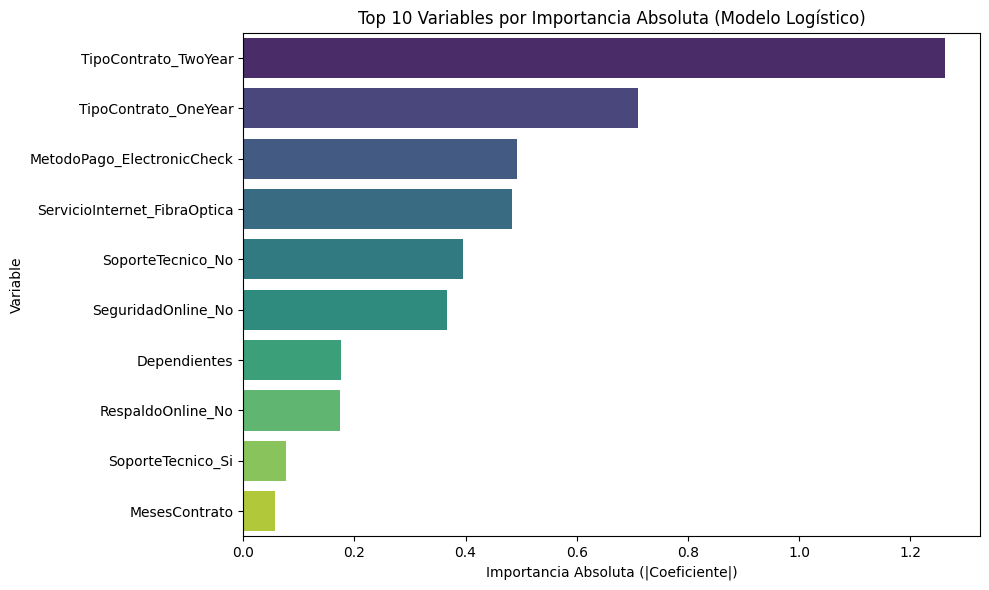

In [45]:
plt.figure(figsize=(10, 6))
sns.barplot(
    data=importancia_log.head(10),
    y='Variable',
    x='Importancia_absoluta',
    palette='viridis'
)

plt.title('Top 10 Variables por Importancia Absoluta (Modelo Logístico)')
plt.xlabel('Importancia Absoluta (|Coeficiente|)')
plt.ylabel('Variable')
plt.tight_layout()
plt.show()

## Tabla resumen de la evaluación de ambos modelos

In [ ]:
datos_modelos = {
    'Modelo': ['Regresión Logística', 'Random Forest'],
    'Accuracy': ['75%', '77%'],
    'Precision (Clase 1)': ['52%', '59%'],
    'Recall (Clase 1)': ['75%', '48%'],
    'F1-score (Clase 1)': ['0.61', '0.53']
}

tabla_comparativa = pd.DataFrame(datos_modelos)

## Evaluación de los Modelos

**¿Qué modelo tuvo el mejor desempeño? ¿Algún modelo presentó overfitting o underfitting?**

Al comparar ambos modelos, se observa que Random Forest tiene mejor precisión que Regresión Logística, pero su recall es peor. Aunque Regresión Logística tiene menor precisión, su recall es mucho mejor, lo cual es clave para identificar a los clientes que cancelan.

📉 Random Forest

Por un lado, Random forest presentó un bajo recall en clase 1 (48%), lo que indica que no está capturando bien a los clientes que cancelan. Esto indica un underfitting leve o una falta de optimización de hiperparámetros. Un ajuste que se podría hacer para solucionar esto es probar RandomizedSearchCV o GridSearchCV para mejorar su sensibilidad.

📈 Regresión Logística

Por otro la lado, Regresión Logística presentó un recall en clase 1 muy alto (75%) pero precisión baja (52%): predice muchas cancelaciones, pero muchas son falsas. Esto puede deberse a un desbalance de clases (solo ~27% cancelan), pues el modelo está penalizado por falsos positivos.

Una posible solución a esto es aplicar class_weight='balanced', tambien se podría usar una métrica optimizada (como ROC-AUC) o ajustar el umbral de clasificación.

Al ser la prioridad detectar la mayor cantidad posible de clientes en riesgo de cancelar, la regresión logística es el modelo más efectivo.

In [47]:
display(tabla_comparativa)

,Modelo,Accuracy,Precision (Clase 1),Recall (Clase 1),F1-score (Clase 1)
0,Regresión Logística,75%,52%,75%,0.61
1,Random Forest,77%,59%,48%,0.53


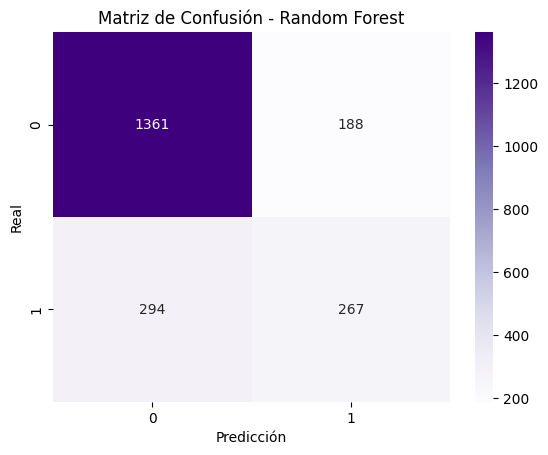

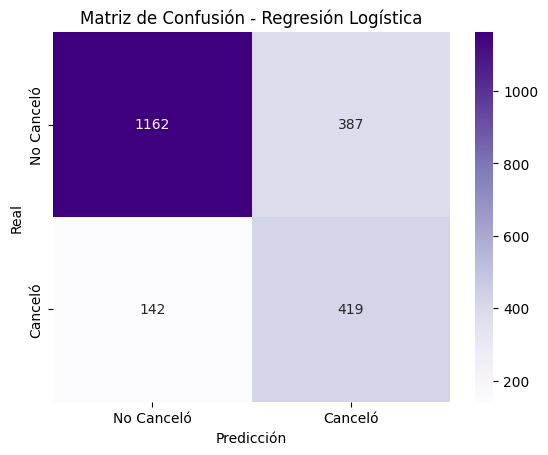

# Interpretación & Conclusiones

### Análisis de la Importancia de las Variables

Ambos modelos destacan `PagoMensual`, `SoporteTecnico_No`, `SeguridadOnline_No`, `MetodoPago_ElectronicCheck` y `ServicioInternet_FibraOptica` como factores claves de riesgo. Esto también se observó en la etapa de evaluación de correlación con la variable Cancelación, pues estas variables tuvieron un nivel de correlación alto.

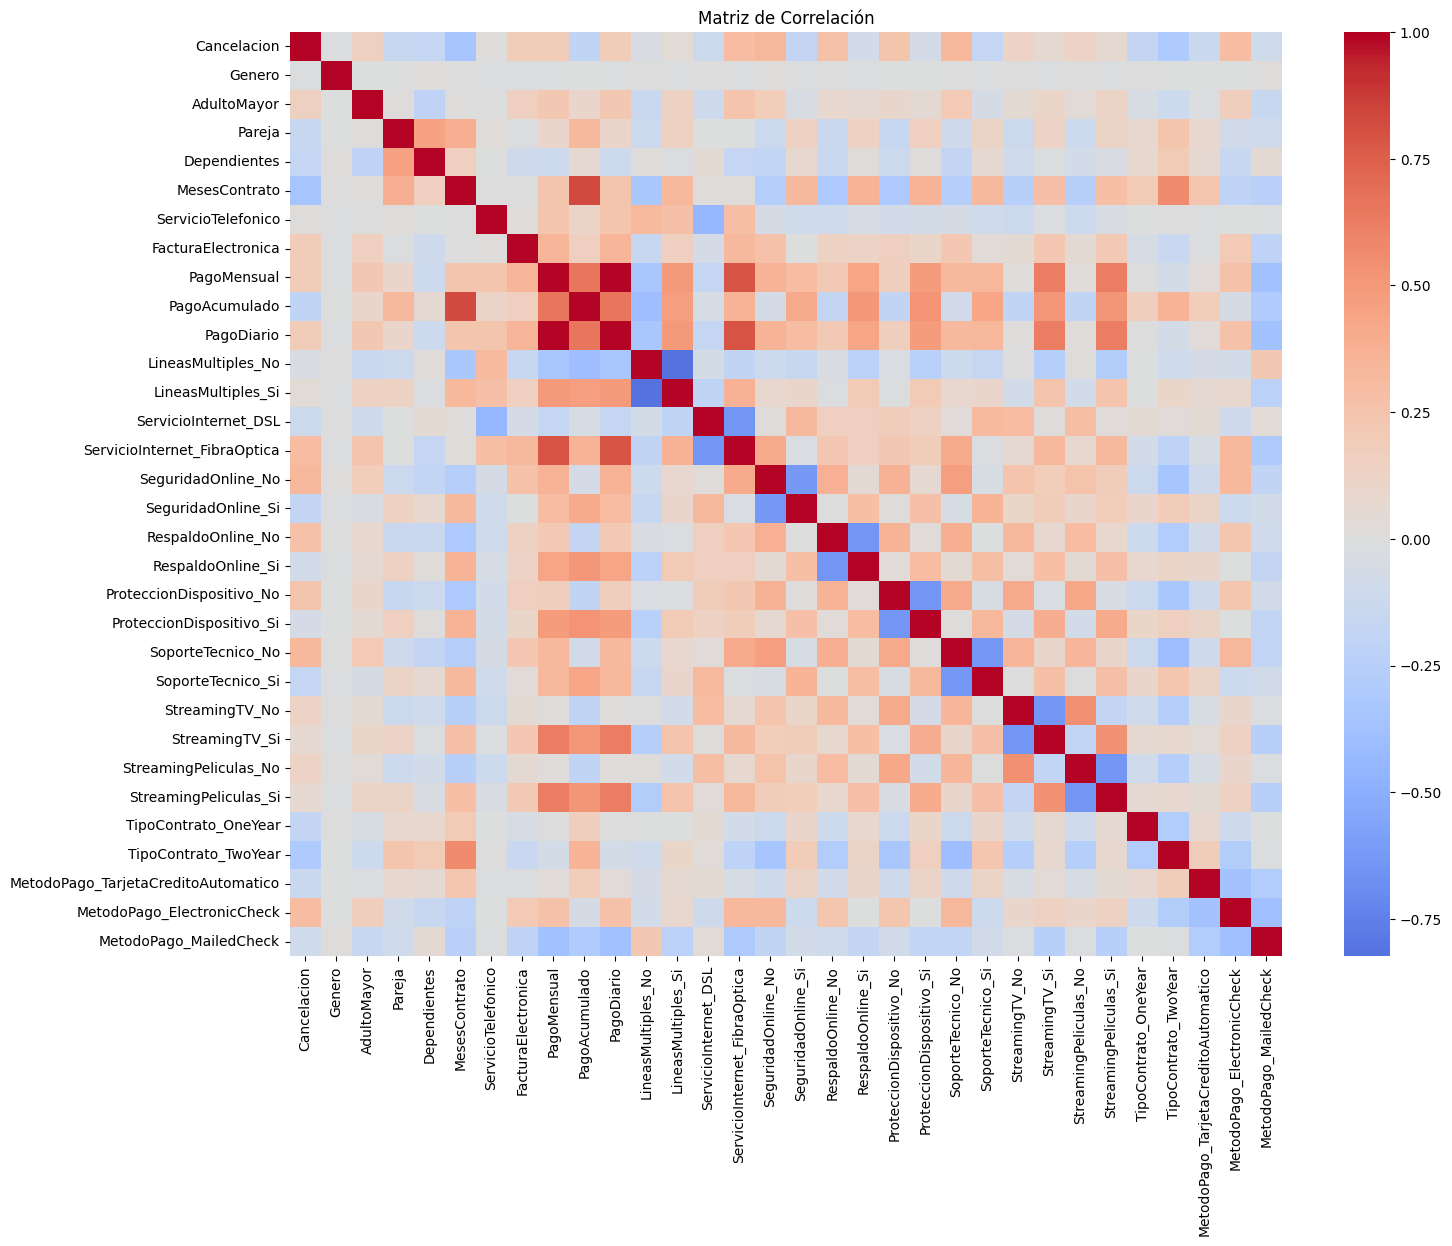

En el caso de Random Forest, el modelo calcula cuánto contribuye cada variable a mejorar las predicciones del modelo, sin indicar si esa variable aumenta o disminuye la probabilidad de cancelación.

Las variables con mayor poder predictivo se relacionan directamente con los pagos y la antigüedad del cliente. Quienes han acumulado más pagos y tienen contratos más largos tienden a quedarse.

Por otro lado, quienes pagan más cada mes, o llevan poco tiempo con la empresa, son más propensos a cancelar. Esto refuerza la idea de que la retención es más difícil en los primeros meses, especialmente si el cliente percibe un costo elevado.

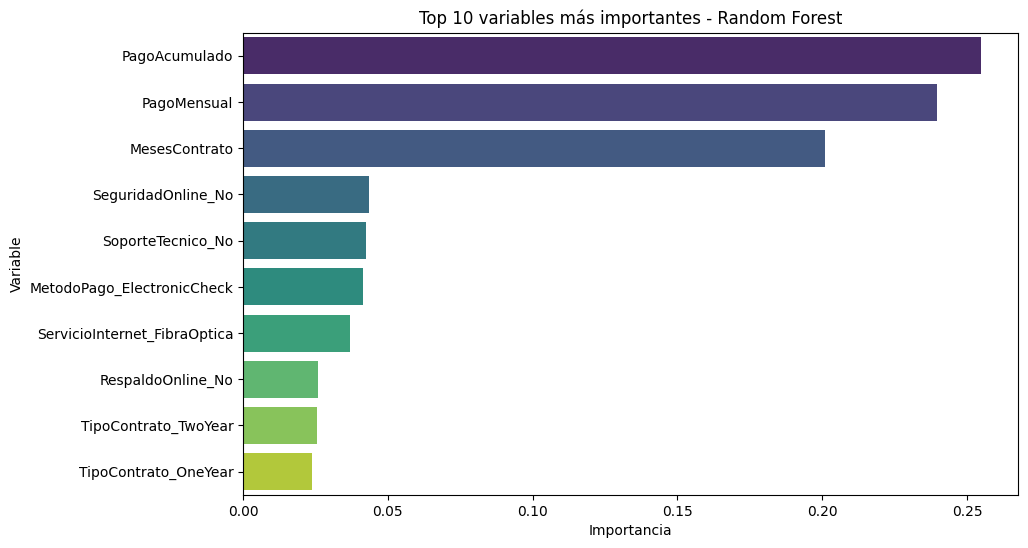

En el caso de Regresión Logística, el modelo revela qué tan fuerte y en qué dirección influye cada variable en la probabilidad de cancelación.

Por ejemplo, los clientes con contratos más largos, como de uno o dos años, tienen mucho menor riesgo de cancelar. Esto indica que los contratos de largo plazo generan mayor compromiso o satisfacción.

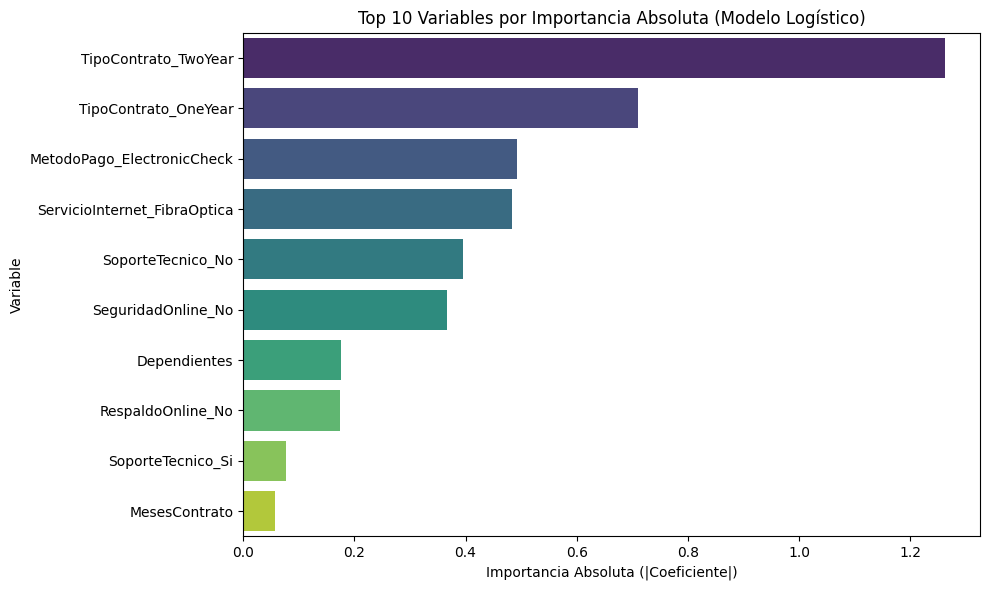

Por el contrario, los clientes que pagan con cheques electrónicos y los que no tienen servicios adicionales como soporte técnico o seguridad en línea, tienden a irse con más facilidad.

Además, los clientes con conexión de fibra óptica tienen una mayor probabilidad de cancelar, posiblemente por expectativas no satisfechas en calidad o costo del servicio.

## 🧾 Informe Final: Conclusiones del Análisis de Cancelación de Clientes

##🎯 Objetivo del Proyecto

Este análisis tuvo como propósito identificar los principales factores que influyen en la cancelación de clientes en TelecomX. Para ello, se entrenaron dos modelos de machine learning:

✅ Regresión Logística, que requiere normalización de los datos.

🌳 Random Forest, que no necesita normalización y puede capturar relaciones no lineales.

### ⚙️ Modelos Evaluados y Rendimiento

Se evaluaron ambos modelos con los datos de prueba. A continuación, se presentan sus métricas clave:

In [48]:
display(tabla_comparativa)

,Modelo,Accuracy,Precision (Clase 1),Recall (Clase 1),F1-score (Clase 1)
0,Regresión Logística,75%,52%,75%,0.61
1,Random Forest,77%,59%,48%,0.53


A partir de estos datos, se encontró que, aunque Random Forest obtuvo una precisión general levemente superior, su recall fue más bajo. Es decir, falló más al identificar a los clientes que realmente se iban.

Por el contrario, la regresión logística fue más sensible a detectar cancelaciones, lo cual es crucial si el objetivo es prevenirlas.

Por ello,  el modelo elegido fue Regresión Logística, debido a su mayor capacidad para identificar clientes en riesgo de cancelar.

### 📌 Factores Clave de Cancelación
📉 Según Regresión Logística

Al observar los coeficientes del modelo, identificamos variables que aumentan o reducen significativamente la probabilidad de cancelación. Los coeficientes negativos indican menor probabilidad de cancelación, mientras que los positivos indican mayor riesgo.

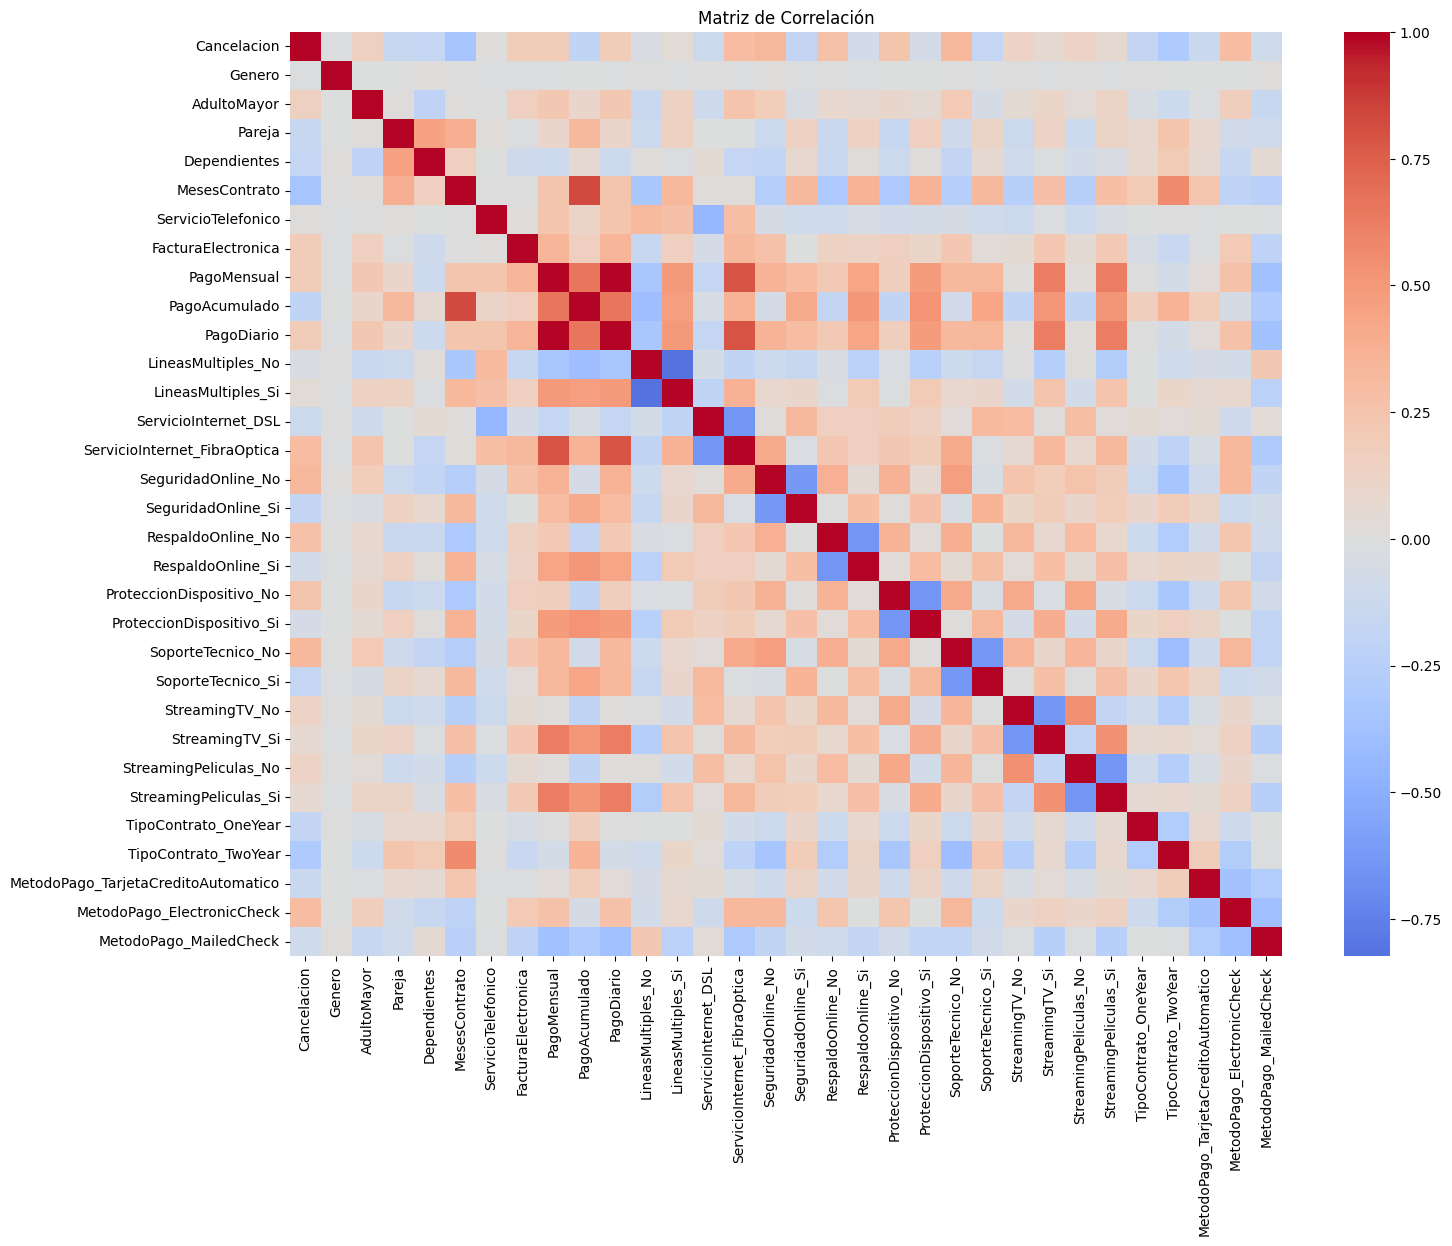

Por ejemplo, los clientes con Fiber optic son más propensos a irse. En el grafico se observa que casi 1 de cada 2 clientes con fibra óptica se va. Esto puede indicar problemas con el servicio relacionadas al precio, calidad o expectativas altas no cumplidas. En otras palabras, el servicio de internet es una variable altamente relacionada con la cancelación, especialmente fibra óptica.

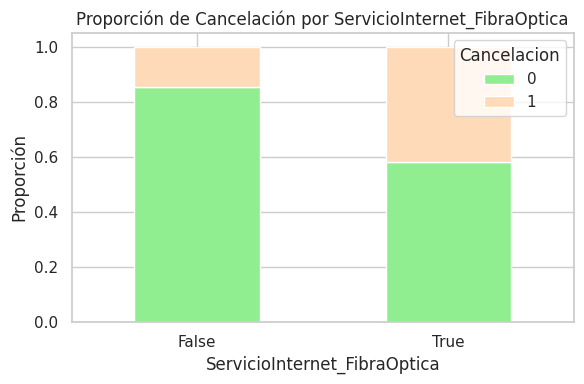

Estos resultados muestran que clientes con contratos largos y con servicios adicionales tienden a permanecer más tiempo en la empresa. En cambio, clientes sin servicios adicionales y con métodos de pago menos automatizados son más propensos a cancelar.

### 🌲 Random Forest

Random Forest permitió analizar la importancia relativa de las variables para la predicción, independientemente de la dirección del efecto. Esto indicaría que variables relacionadas con el comportamiento de pago y la antigüedad del cliente son fuertes predictores de cancelación. Clientes con poco tiempo en la empresa y pagos mensuales elevados tienden a cancelar con mayor frecuencia.

Por ejemplo, los clientes que se quedan tienen una mediana de duración de contrato mucho más alta (alrededor de 40 meses), mientras que los que se van cancelan típicamente dentro de los primeros 10 meses. Esto sugiere que si el cliente permanece más de un año, su probabilidad de cancelar disminuye considerablemente.

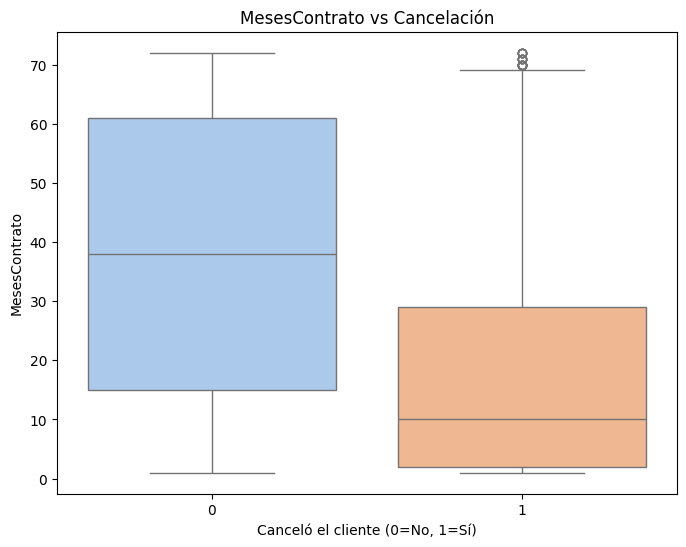

###💡Recomendaciones
A partir del análisis de los modelos y las variables más relevantes, se identificaron varias estrategias para reducir la cancelación de clientes. En primer lugar, se recomienda fomentar contratos de uno o dos años, ya que este tipo de compromisos se asocia con una menor probabilidad de cancelación.

Asimismo, incentivar el uso de métodos de pago automáticos, como la domiciliación bancaria, podría ser beneficioso, ya que se observó que el uso de Electronic Check está relacionado con una mayor tasa de cancelación. También se sugiere ofrecer servicios adicionales, como seguridad o soporte técnico, ya que estos contribuyen a disminuir el riesgo de abandono.

Por otro lado, se identificó que los clientes nuevos, especialmente aquellos con pocos meses de antigüedad, presentan una mayor propensión a cancelar, por lo que se recomienda brindarles una atención especial durante sus primeros meses.

Finalmente, se plantea la necesidad de revisar las tarifas aplicadas a clientes con pagos mensuales elevados, dado que un PagoMensual alto se vincula con una mayor probabilidad de cancelación.

### ✅ Conclusión

En conclusión, el análisis ha permitido identificar patrones claros en la cancelación de clientes. La regresión logística ha sido el modelo más útil al capturar mejor a los clientes que cancelan. Las decisiones estratégicas enfocadas en contratos, métodos de pago y servicios agregados pueden mejorar significativamente la retención de clientes.